<a href="https://colab.research.google.com/github/ShawnLiu119/NLP_Bank_Complaint_Classification/blob/main/CustomerComplaint_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Customer Complaint Classification - NLP Topic Modelling**

In [2]:
import json #data format
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import os

# Load English tokenizer, tagger, parser and NER
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

**Named entity recognition (NER)** is a natural language processing (NLP) method that extracts information from text. NER involves detecting and categorizing important information in text known as named entities.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd

/root


In [5]:
folder = "/content/drive/MyDrive/kaggle_data/complaints"
file = "complaints-2021-05-14_08_16_.json"

path = os.path.join(folder, file)

#open JSON file
f = open(path)
data = json.load(f)

type(data)

list

In [6]:
df=pd.json_normalize(data)
#convert a list of dictionary (loaded from JSON file) into a flat table, missmatch part will return NaN, use this function to convert to structrual data

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
def value_counts(df, cols):
  for col in cols:
    print(f'\n columns {col}')
    print(df[col].value_counts())

cols = ['_source.issue', '_source.product', '_source.sub_product']
value_counts(df, cols)


 columns _source.issue
_source.issue
Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Unable to get credit report/credit score                                              1
Advertising, marketing or disclosures                                                 1
Problem with an overdraft                                                             1
Can't stop withdrawals from your bank account                                         1
Money was taken from your bank account on the wrong day or for the wrong amount   

### Data Preprocessing

1. rename columns after json normalization (flat table)
2. impute "complaint" column by removing
3. Lower case / punctuation, remove text in square bracket, remove words containing numbers??? why
4. POS tags to get relevant words from the texts. Using Nouns just
5. Lemmatize the text

Reference:
https://www.analyticsvidhya.com/blog/2020/07/part-of-speechpos-tagging-dependency-parsing-and-constituency-parsing-in-nlp/#:~:text=Part%2Dof%2DSpeech%20(POS)%20tagging%20is%20a%20preprocessing,each%20word%20in%20a%20sentence.

**POS - Part-of-Speech Tagging** <br>
Part-of-Speech (POS) tagging is a natural language processing technique that involves assigning specific grammatical categories or labels (such as nouns, verbs, adjectives, adverbs, pronouns, etc.) to individual words within a sentence <br>
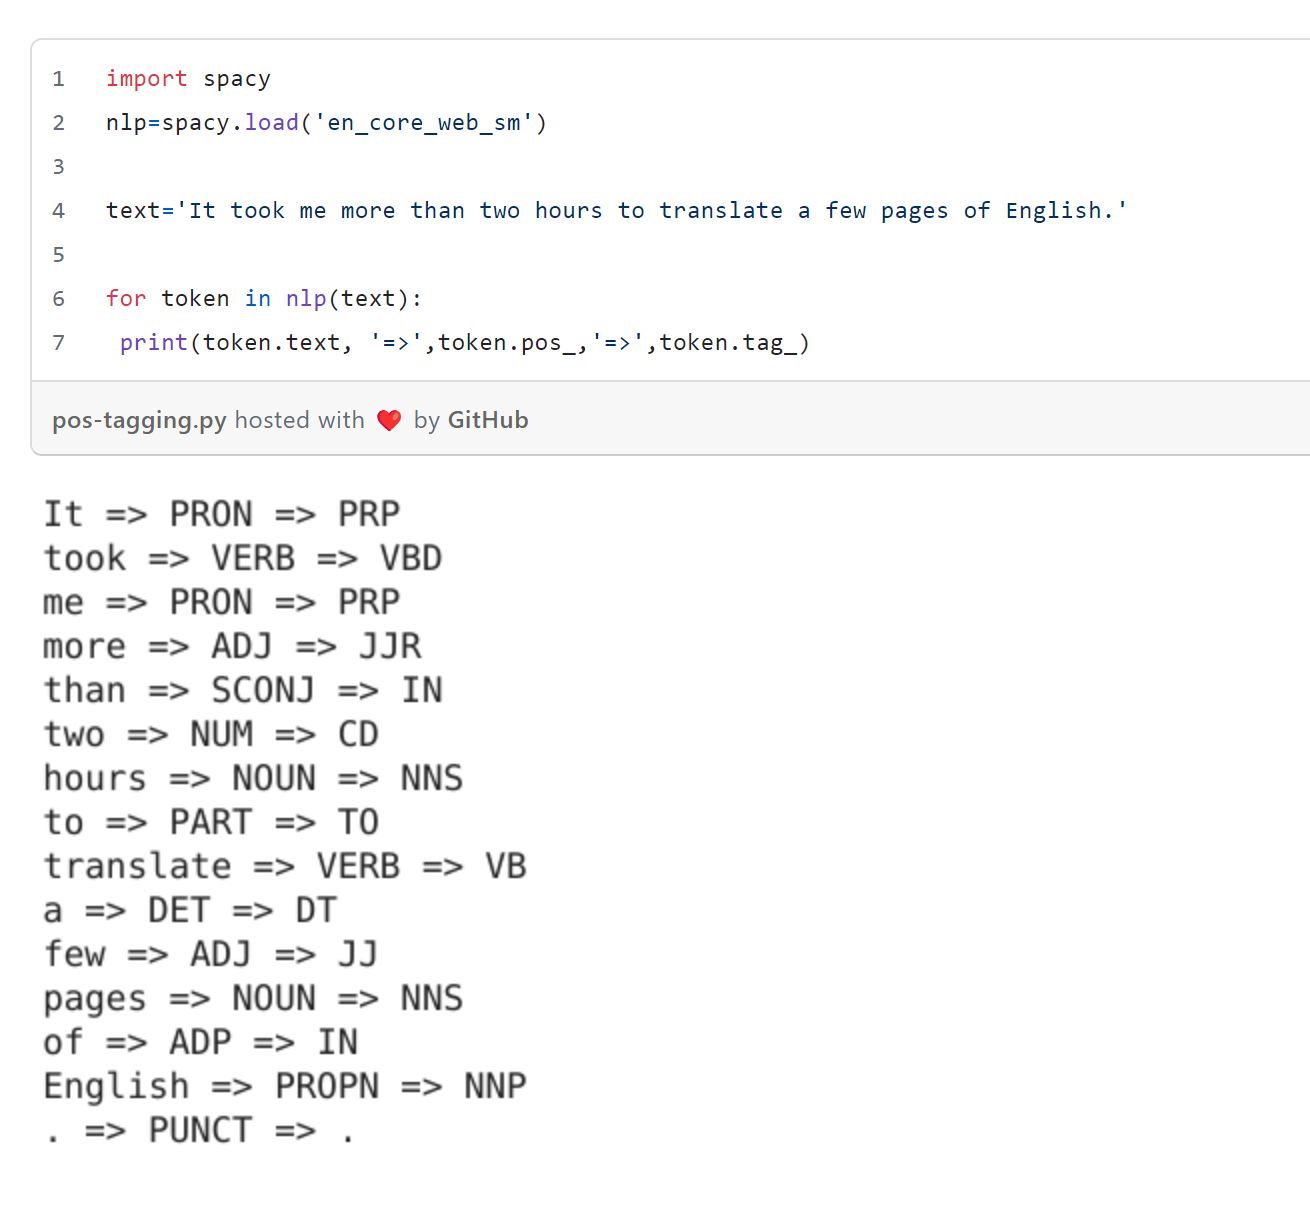

**Dependency Parsing** <br>
Dependency parsing is the process of analyzing the grammatical structure of a sentence based on the dependencies between the words in a sentence. <br>
**head**
**dependent/child** is associated with or based on head
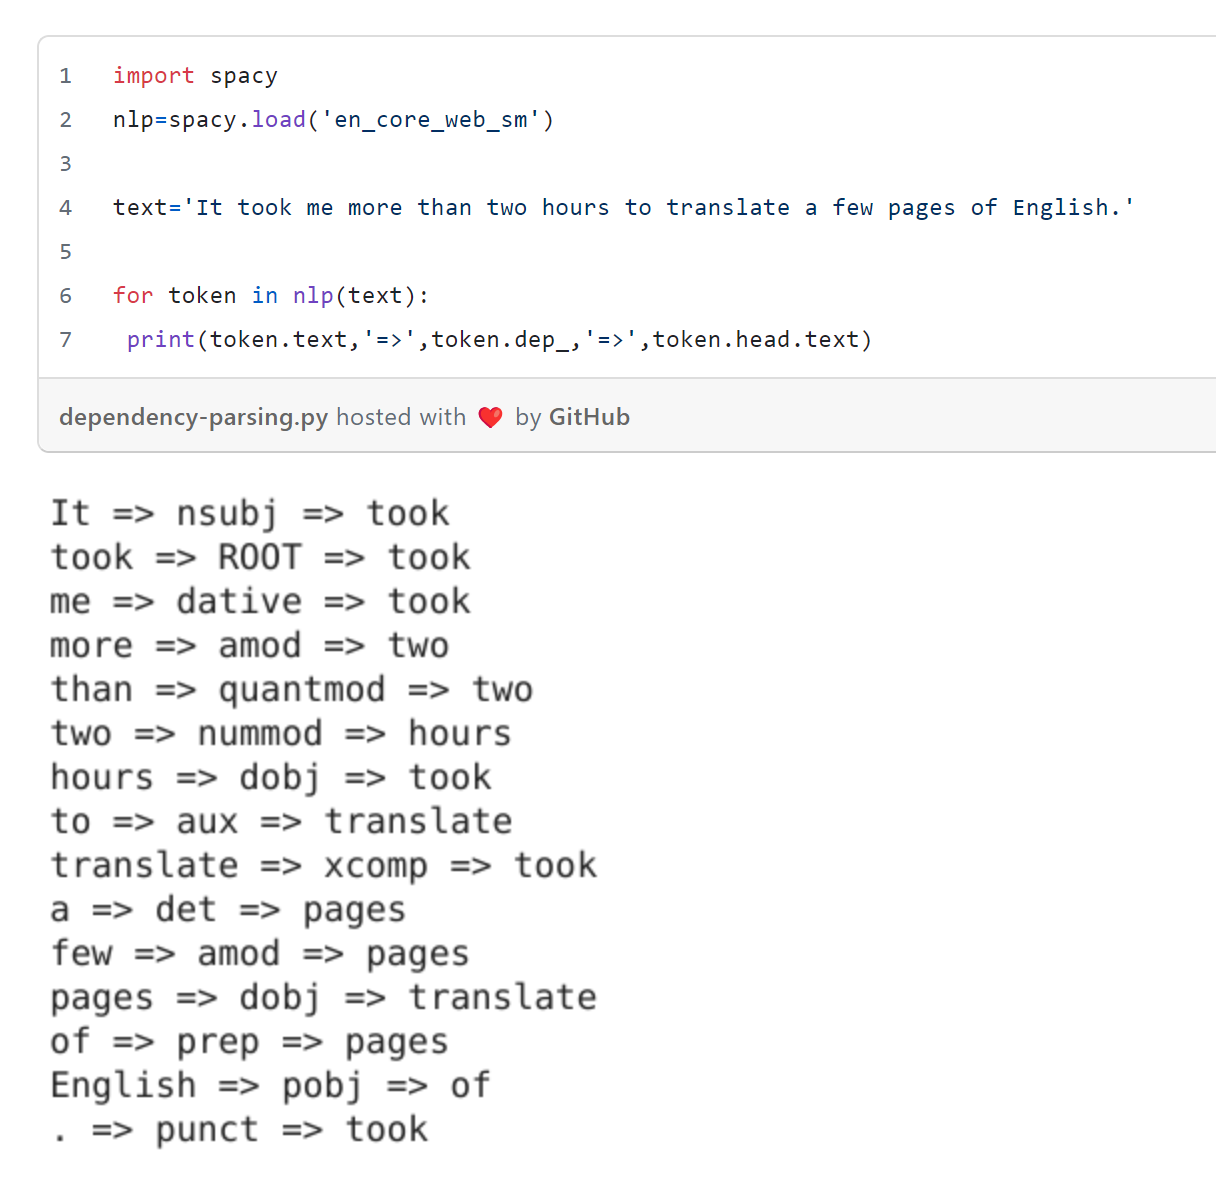


**Constituency Parsing Aid** <br>

Constituency Parsing is the process of analyzing the sentences by breaking down it into sub-phrases also known as constituents. These sub-phrases belong to a specific category of grammar like NP (noun phrase) and VP(verb phrase). <br>
NP: Noun Phase <br>
VP: Verb Phase <br>
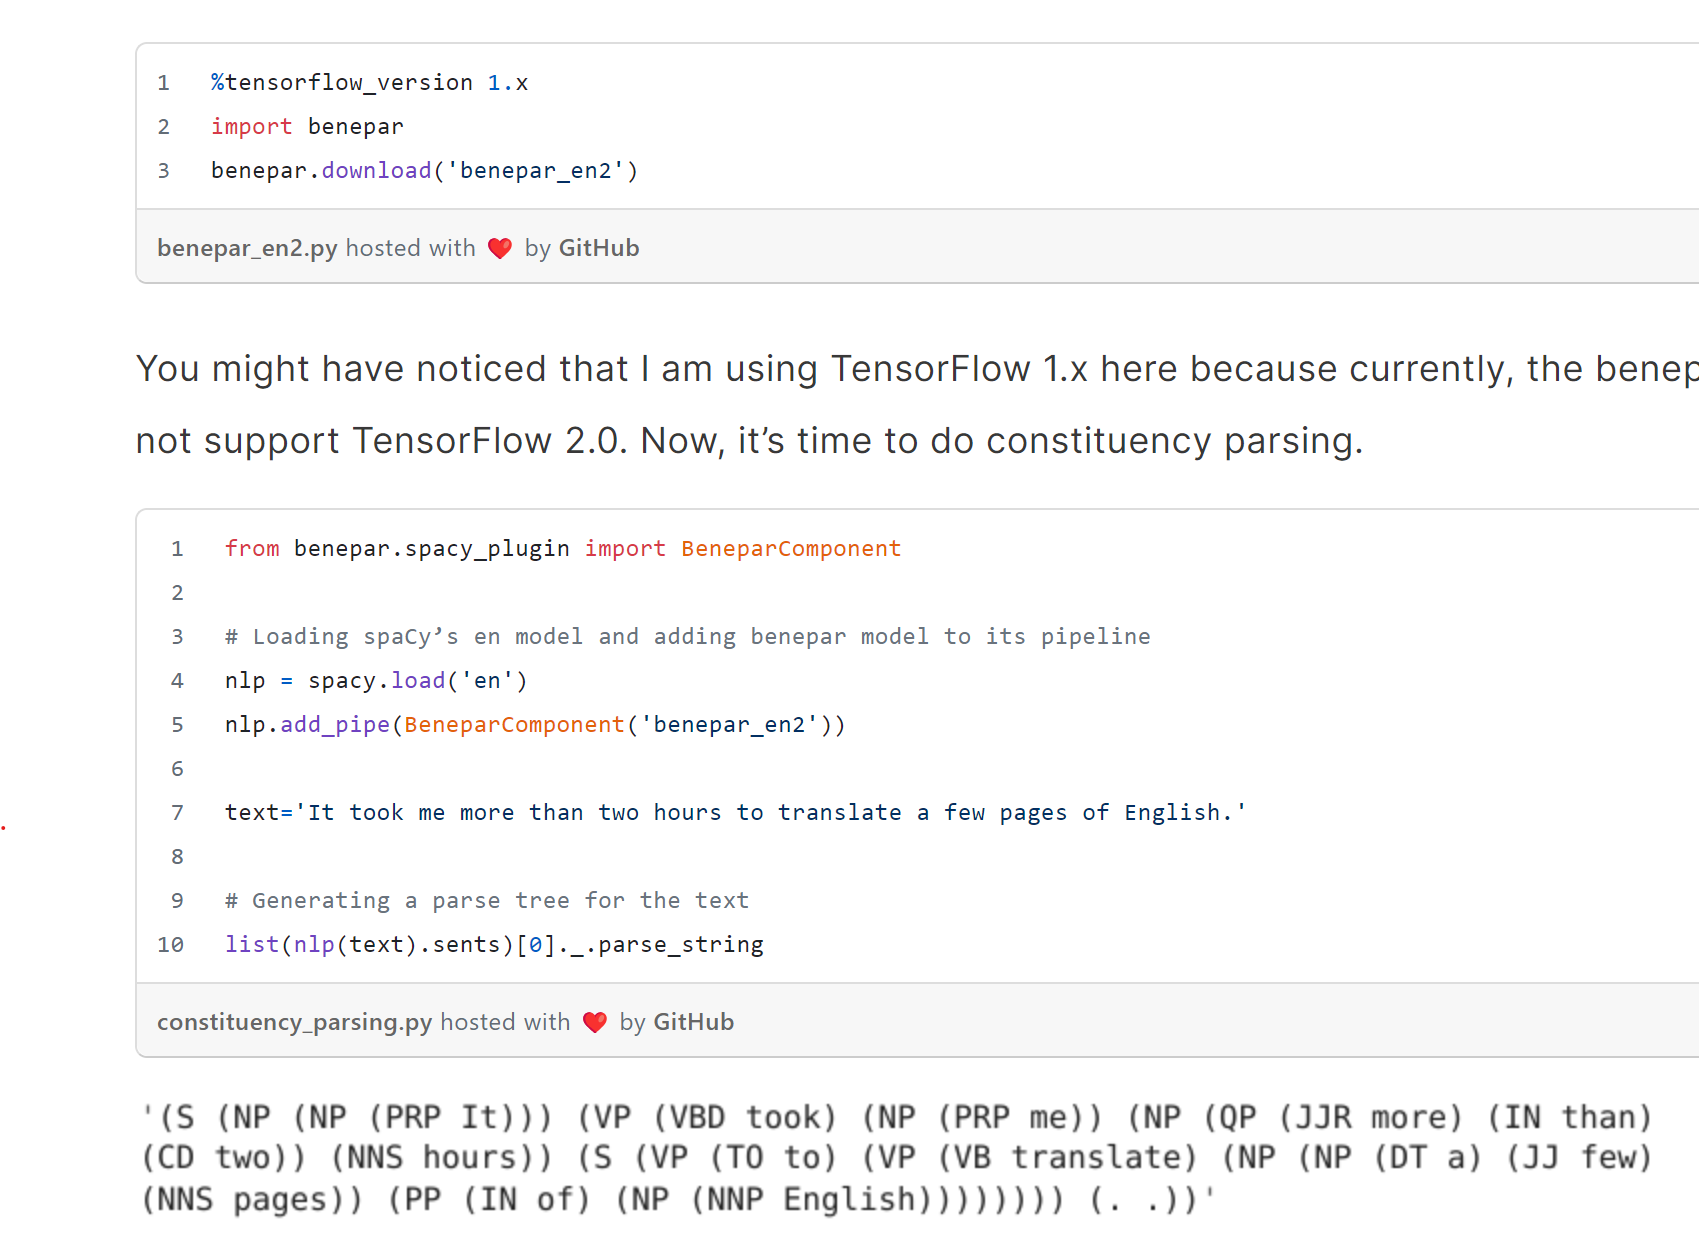

In [10]:
#Assigning new column names
df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state",
              "consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company",
              "company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [11]:
#Assigning nan in place of blanks in the complaints column(complaint_what_happened)
df[df['complaint_what_happened']==''] = np.nan

In [12]:
#because we are analyzing the complaint, we will remove all rows where complaints colum is nan, [no data for analysis]
df = df.dropna(subset=['complaint_what_happened'])

df.shape

(21072, 22)

In [13]:
import re, nltk, spacy, string
pd.options.mode.chained_assignment = None
df.complaint_what_happened=df.complaint_what_happened.astype(str)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean_text(x)))

The regular expression \[.*?\] is used to match any text that is enclosed within square brackets. Let's break down the components of this regular expression:

1. **\[**: The backslash \ is an escape character that allows us to treat the following character as a literal. Here, it is escaping the opening square bracket [, so it matches a literal [.

2. **.*?**: This part consists of three characters:

 - .: This matches any character except a newline.

 - *: This is a quantifier that matches 0 or more occurrences of the preceding element (which is . in this case). This means it will match as many characters as possible.

 - ?: This makes the preceding quantifier (* in this case) non-greedy (or lazy). By default, * is greedy, meaning it will match as much text as possible. Adding ? makes it match as little text as possible, which is useful to ensure it stops at the first closing bracket ] rather than matching all the way to the last closing bracket in the text.
3. **\]**: Similar to \[, the backslash \ here escapes the closing square bracket ], so it matches a literal ].

**\: escape a string** -- Any quote that is preceded by a slash is escaped, and understood to be part of the value of the string.

The expression **[%s]' % re.escape(string.punctuation)** is used to create a regular expression pattern that matches any character in the string.punctuation set. Let's break this down step by step:

**string.punctuation**: This is a string constant in the string module of Python. It contains all the punctuation characters, <br>
output: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

**re.escape(string.punctuation)**: The re.escape function is used to escape all the characters in string.punctuation that have special meanings in regular expressions. This is necessary because punctuation characters like ., *, ?, [ and ] are special characters in regular expressions and need to be escaped to be treated as literal characters. The result of re.escape(string.punctuation) is: <br>
output:!"#\$%&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}~

**[%s]' % re.escape(string.punctuation)**: This uses Python's string formatting to insert the escaped punctuation characters into a character class. The %s (*The %s operator lets you add a value into a Python string. The %s signifies that you want to add a string value into a string*) is replaced by the result of re.escape(string.punctuation). The character class [...] matches any single character contained within the brackets. Therefore, the final regular expression pattern is:<br>
output: [!"#\$%&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}~]

The regular expression r'\w*\d\w*' is designed to match any string that contains at least one digit (\d) and may have word characters (\w) before and after the digit. Let's break down the components of this regular expression:

1. \w*:

 - \w: This matches any word character (alphanumeric characters and underscores), equivalent to [a-zA-Z0-9_].
 - *: This quantifier means "zero or more" of the preceding element (\w in this case). So, \w* matches any sequence of word characters, including an empty sequence.
2. \d:
 - \d: This matches any digit, equivalent to [0-9].
3. \w* (again):
 - This is the same as the first part, matching any sequence of word characters (including an empty sequence) following the digit.

In summary, r'\w*\d\w*' matches a string that:
- May start with zero or more word characters.
- Contains at least one digit.
- May end with zero or more word characters.

**Lemmatization**
sort words by grouping inflected or variant forms of the same word.

In [14]:
#Function to Lemmatize the texts
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent) #use " "space to join a lit of lemmatized words

In [15]:
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [16]:
#Creating a dataframe that will have only the complaints and the lemmatized complaints.
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean["Complaint_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [17]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [18]:
df_clean.to_csv('df_lemm,csv')

'''One thing to notice is unlike verbs and common nouns, there's no clear base form of a personal pronoun.
Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"?
spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.'''

**Chunking** <br>
Chunking in NLP is a process to take small pieces of information and group them into large units. The primary use of Chunking is making groups of "noun phrases

Chunking is a Natural Language Processing (NLP) technique that **breaks down sentences into phrases that are more useful than single words**. It involves analyzing a sentence to identify constituents like noun groups, verbs, and verb groups. Chunking can be done in two ways: chunking up and chunking down:

**Chunking up**
Makes language more abstract and increases the chances of agreement. For example, asking "for what purpose cars?" may result in the answer "transport", which is a higher chunk and more abstract.

**Chunking down**
Looks for specific details that may have been missing in the chunk up. For example, asking "what specifically about a car?" may result in smaller pieces of information about a car.

**Chunking works on top of POS tagging, using POS-tags as input and providing chunks as output. A standard set of chunk tags include Noun Phrase (NP) and Verb Phrase (VP). **



In [22]:
#download the nltk package as prerequsite for TextBlob
import nltk
nltk.download('punkt') #to install the missing module (the Perceptron Tagger).

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [26]:
#test purpose to see how TextBlob was used to do the POS tagging

# wiki = TextBlob("Python is a high-level, general-purpose programming language.")
# wiki.tags

[('Python', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('high-level', 'JJ'),
 ('general-purpose', 'JJ'),
 ('programming', 'NN'),
 ('language', 'NN')]

In [27]:
#Here we are using only noun, singular as we have already lemmatized the texts.
import pandas as pd
from textblob import TextBlob

def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"]) ##NN noun

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_adjectives(x['Complaint_lemmatize']), axis=1) #extract only Noun tokens

In [35]:
df_clean.head(20)

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
15,can you please remove inquiry,can you please remove inquiry,inquiry
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,xxxx payment online retailer use pay xxxx chas...
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...


**TextBlob** is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [30]:
df_clean.to_csv('/content/drive/MyDrive/kaggle_data/complaints/preprocessed_nlp.csv')

### EDA

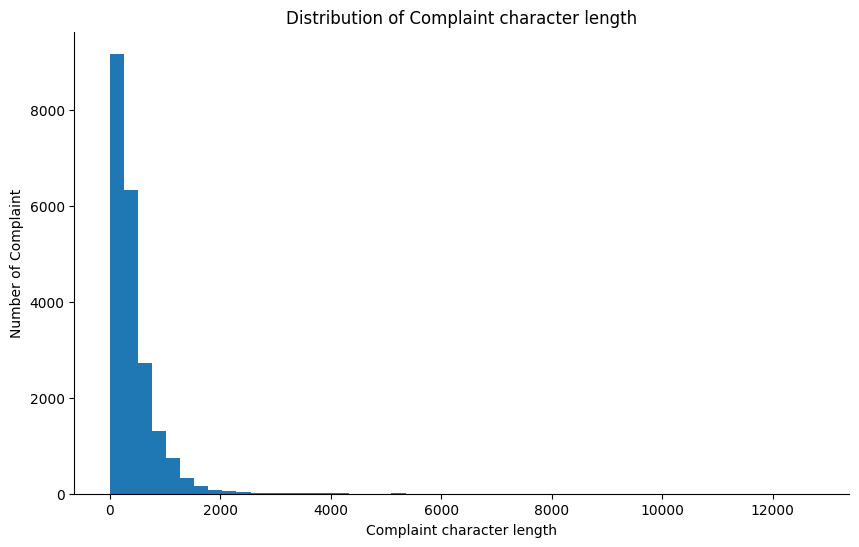

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed] #count # of nouns in each complaints
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

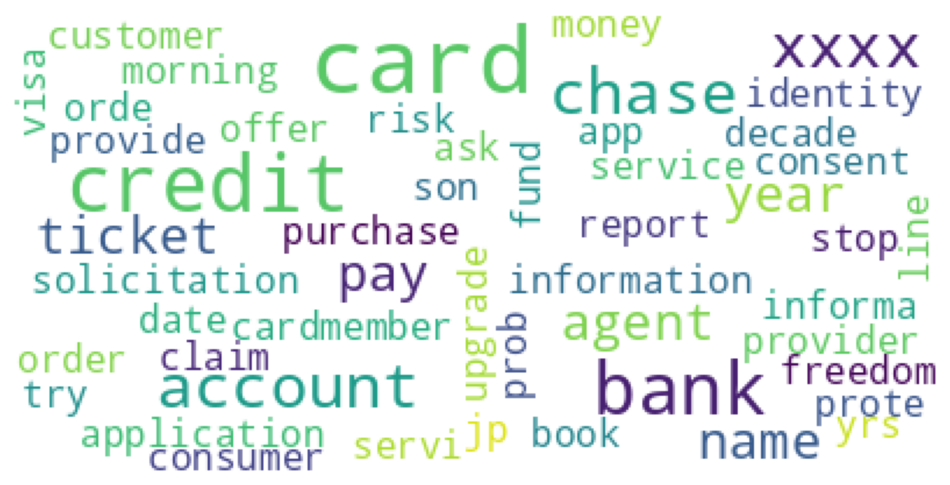

In [32]:
#Top 50 words sorted by frequency across all the complaints after processing

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output #Run command with arguments and return its output.
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [36]:
def search_pron(df):
  pron_list = []
  for x in df:
    for word in x:
      if '-PRON-' in word:
        pron_list.append(word)
  return pron_list

search_pron(df_clean['complaint_POS_removed'])

[]

In [37]:
#Removing -PRON- from the text corpus - There is no -PRON- contained in any string
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [42]:
df_clean.query('Complaint_clean != complaint_POS_removed')

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean


#### Look into bigrams, trigrams by frequency across all complaints

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from pprint import pprint
# def get_top_n_words(corpus, n=None):
#     vec = CountVectorizer(stop_words='english').fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0)
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:n]
# common_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 50)
# df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
# fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
# fig.show()

In [45]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus) #default ngram is unigram, while (2,2) only for bigram
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return sum_words, words_freq[:n]


sum_words, bigram_words = get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'), 30)

df3 = pd.DataFrame(bigram_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

**bag_of_words** a matrix where each row represents a specific text in corpus and each column represents a word in vocabulary, that is, all words found in corpus. Note that bag_of_words[i,j] is the occurrence of word j in the text i.

**sum_words** is a vector that contains the sum of each word occurrence in all texts in the corpus. In other words, we are adding the elements for each column of bag_of_words matrix.

In [55]:
sum_words.max() #return the bigram that appears the most times in all, which is 'credit card'

12778

In [43]:
df_clean['Complaint_clean'].values.astype('U') #corpus, you do not need to join them together

array(['morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help',
       'card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent',
       'card report application identity consent service credit identity applicant',
       ...,
       'pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communication website say merchant look face brand link medium consent research phone number information pi merchant account title holder cycle fraud fix voip identity xxxx bank tell report report recourse matter protocol place issue chase verbiage point position app branch chase banking service degree entitlement customer service protection protocol chase back read link tab place consumer risk use service concern chase slight risk use xxxx banking app public plan report correspond authority individual identity neigh

In [57]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus) #default ngram is unigram, while (2,2) only for bigram
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

trigram_words = get_top_n_trigram(df_clean['Complaint_clean'].values.astype('U'), 30)

df4 = pd.DataFrame(trigram_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [58]:
df4.head(5)

,trigram,count
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,633
4,credit card credit,513


#### We found encrypted info which starts with 'XXXX XXXX' like credit card No etc. will remove those masked text

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

### **Convert the raw texts to a matrix of TF-IDF feature**

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [59]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=3, stop_words='english')

#The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score: The tuples that are not there have a tf-idf score of 0
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [63]:
print(dtm[0:10])

#(complaint_id,token_id) tf-idf score

  (0, 2377)	0.1718832728047438
  (0, 99)	0.2570747720636594
  (0, 5073)	0.19709737832792926
  (0, 35)	0.07898227609521723
  (0, 805)	0.07084896999311896
  (0, 1098)	0.17722875633716392
  (0, 2619)	0.12672013926743692
  (0, 4390)	0.207509247785477
  (0, 3268)	0.1268349149425656
  (0, 3028)	0.1695941145248185
  (0, 4820)	0.15619094706442332
  (0, 5383)	0.2515847346806849
  (0, 1333)	0.5491038012691636
  (0, 302)	0.19491710979028296
  (0, 4572)	0.1336931370449104
  (0, 708)	0.31575260369943176
  (0, 421)	0.17975536774196882
  (0, 4850)	0.29773535306488147
  (0, 3279)	0.23055612504127443
  (1, 4142)	0.3159366649289865
  (1, 5574)	0.08390556902488865
  (1, 1072)	0.27142760478666206
  (1, 5588)	0.13177879741145482
  (1, 787)	0.21082381695379374
  (1, 3503)	0.18101960111822427
  :	:
  (8, 1281)	0.06835777283370897
  (8, 2646)	0.05217008086461109
  (8, 871)	0.07607987905498897
  (8, 3414)	0.06773873689965824
  (8, 5131)	0.025318763818506958
  (8, 3259)	0.03140412939695528
  (8, 3627)	0.0422036

### **NMF**
**Non-Negative Matrix Factorization (NMF)** is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

https://www.geeksforgeeks.org/non-negative-matrix-factorization/

In [64]:
from sklearn.decomposition import NMF

### **Coherence Model to select best number of Topics**

**Topic coherence** has been proposed as an intrinsic evaluation method for topic models [9, 10]. It is defined as average or median of pairwise word similarities formed by top words of a given. topic.

In [65]:
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [66]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['Complaint_clean']
dataset = [d.split() for d in texts] #split each complaint into a list of words

In [68]:
# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

In [72]:
# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

corpus[0:2] #first two complaints, (token_id, token_count)

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 3),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(0, 1),
  (9, 1),
  (20, 3),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)]]

#### **Conherence Score**
reference:
https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c


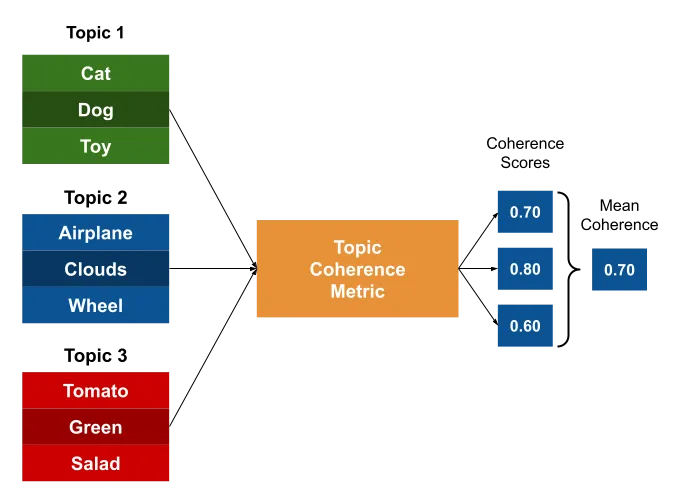

I've found the source of the error. When one of the top words of the topics of the trained model has a word frequency count of 0 in the test corpus, the CoherenceModel will throw this warning and output 'nan' value.

I've make a small addition to the 'gensim.topic_coherence.direct_confirmation_measure.log_ratio_measure' function. You can place this function in a separate .py file and import it into your main. There, you can overwrite the the regular 'log_ratio_measure' function with the custom one.

https://github.com/piskvorky/gensim/issues/3040

In [73]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(scores)
print(best_num_topics)

[(5, nan), (6, nan), (7, nan), (8, nan), (9, nan)]
5


## **Topic Modelling**

In [74]:
nmf_model = NMF(n_components=5,random_state=123) #n_components is the best coherent topics you get from coherence score

In [76]:
nmf_model.fit(dtm) #the input fed in are TFIDF features
len(tfidf.get_feature_names_out()) #if run 90% tfidf, there will be 7400 features

5617

In [78]:
#Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names_out()[index])

day
branch
xxxx
deposit
chase
fund
money
bank
check
account


Within the first topic, the most relevant words(token) are day, branch, deposit, etc

In [79]:
#Print Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'transaction', 'business', 'number', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['letter', 'year', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'xxxx', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC #3
['refund', 'time', 'service', 'xxxxxxxx', 'purchase', 'fraud', 'claim', 'merchant', 'fee', 'xxxx', 'chase', 'dispute', 'transaction', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['account', 'chase', 'credit', 'xxxx', 'pay', 'date', 'auto', 'time', 'xxxxxxxx', 'day', 'statement', 'fee', 'month', 'balance', 'payment']




In [85]:
#Creating the best topic for each complaint
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)


array([0.02, 0.01, 0.02, 0.01, 0.01])

In [87]:
topic_results[0:5]
topic_results.shape #return a matrix (x,y) x represent # of complaints, y represents the score for each topics for each complaint

(21072, 5)

In [82]:
topic_results[0].argmax() #Returns the indices of the maximum values along an axis
topic_results.argmax(axis=1)

array([0, 3, 1, ..., 3, 4, 4])

In [93]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [94]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [95]:
#Print the first 5 Complaint for each of the Topics
df_dc=df_clean.groupby('Topic').head(10)
df_dc.sort_values('Topic')

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
92,in several transactions on my chase checking ...,in several transaction on my chase checking ...,transaction chase account report help account ...,transaction chase account report help account ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
69,someone called stating i had felony committed ...,someone call state I have felony commit under ...,someone call state commit security number chec...,someone call state commit security number chec...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
43,chase sent me an email today with the innocuou...,chase send I an email today with the innocuous...,send email today title information regard chan...,send email today title information regard chan...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto xxxx,0
42,my card went missing and i didnt realize it un...,my card go missing and I do not realize it unt...,card today email money bank account go,card today email money bank account go,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
35,i opened the saving account for the bonus i w...,I open the save account for the bonus I be s...,save account bonus bonus auto transfer check t...,save account bonus bonus auto transfer check t...,0


In [96]:
#Create the dictionary of Topic names and Topics - This is a little bit arbitrary
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

In [97]:
#Replace Topics with Topic Names
df_clean['Topic_name'] = df_clean['Topic'].map(Topic_names)

## Supervised Model - predict new-coming complaints to its topic

In [100]:
data = df_clean[["complaint_what_happened","Topic"]] #use for train and test